In [1]:
import numpy as np
import scipy.integrate as intgr
import math as m
import matplotlib.pyplot as plt

Определение иерархии классов для численного интегрирования:

In [2]:
import numpy as np
class AbstractIntegral:
    _MethodName = 'Abstract Integral'
        
    def SetFunction(self, function):
        self._function = function
    
    def SetLeftBorder(self, leftBorder):
        self._leftBorder = leftBorder
        
    def SetGrid(self, step):
        self._step = step
        
    def SetCoeffients(self, points):
        raise NotImplementedError
    
    def getName(self):
        return self._MethodName
    
    def __call__(self, x):
        self._gridArray = np.arange(self._leftBorder, x + self._step, self._step)   
        self._gridLength = len(self._gridArray)
        self.SetCoeffients(self._gridLength)
        
        f, left, right, coeff = self._function, self._leftBorder, x, self._coeffients    
        
        value = 0.
        for i in range(self._gridLength):
            xCurrent = self._gridArray[i]
            value += coeff[i] * f(xCurrent)
            
        value *= self._step
        return value    
    
        
class LeftRectangleIntegral(AbstractIntegral):
    _MethodName = 'Left Rectangle Integral'
    
    def SetCoeffients(self, points):
        self._coeffients = [1] * (points - 1) + [0]

class RightRectangleIntegral(AbstractIntegral):
    _MethodName = 'Right Rectangle Integral'
    
    def SetCoeffients(self, points):
        self._coeffients = [0] + [1] * (points - 1)

class MiddleRectangleIntegral(AbstractIntegral):
    _MethodName = 'Middle Rectangle Integral'
    
    def SetCoeffients(self, points):
        self._coeffients = [0.5] + [1] * (points - 2) + [0.5]

class TrapeziumIntegral(AbstractIntegral):
    _MethodName = 'Trapezium Integral'
    
    def SetCoeffients(self, points):
        self._coeffients = [0.5] + [1] * (points - 2) + [0.5]
    
class SimpsonIntegral(AbstractIntegral):
    _MethodName = 'Simpson Integral'
    
    def SetCoeffients(self, points):
        self._coeffients = [1./3] + [4./3, 2./3] * ((points - 2) / 2)
        if (points % 2 == 1):
            self._coeffients += [4./3]
        self._coeffients += [1./3]

Проверка работы метода трапеций и сравнение интегрированием функцией из SciPy:

In [3]:
parabola = lambda t: t**2


INum = TrapeziumIntegral()
INum.SetFunction(parabola)
INum.SetLeftBorder(0.)
INum.SetGrid(step=1e-3)

# call
resultByOwn = INum(x=1.)
resultByScipy = intgr.quad(parabola, 0., 1.)

print(str(resultByOwn) + ' ' + str(resultByScipy[0]))

0.3333335 0.33333333333333337


Определение функций-"шапочек" из МКЭ:

In [21]:
# a basis function is zero outside the corresponding finite element
class FiniteElementMesh:
    # equally-spaced nodes
    def __init__(self, xL, xR, numNodes):
        self._nodes = list(np.linspace(xL, xR, numNodes, dtype='float64'))
        self._finiteElems = [ [self._nodes[i], self._nodes[i + 1]] \
                             for i in range(len(self._nodes) - 1)] 
        self.h = float(np.diff(self._nodes)[0]) # equally-spaced nodes
    
    def __str__(self):
        counter = 0
        for elem in self._finiteElems:
            print('Elem #%d: [%.2f, %.2f]' % (counter, elem.xL, elem.xR))
            counter += 1
    

class BasisFunction:
    # the index "i" of a basis function: 1 <= i <= numNodes - 2
    
    def __init__(self, mesh, index):
        self._mesh = mesh
        self._i = index # "i" is a parameter
    
    def __call__(self, x):
        xArrayMesh = self._mesh._nodes # for short
        i = self._i # for short, too
        #print('Ha-ha %.2f' % xArrayMesh[0])
        
        # "hat" function
        if i != 0 and i != len(xArrayMesh) - 1:
            if x >= xArrayMesh[i - 1] and x < xArrayMesh[i]:
                return (x - xArrayMesh[i - 1]) / self._mesh.h
            elif x >= xArrayMesh[i] and x < xArrayMesh[i + 1]:
                return 1. - (x - xArrayMesh[i]) / self._mesh.h
            else:
                return 0.
        
        # left "half hat" function
        elif i == 0:
            if x >= xArrayMesh[0] and x < xArrayMesh[1]:
                return 1. - (x - xArrayMesh[i]) / self._mesh.h
            else: 
                return 0.
        
        # right "half-hat" function
        elif i == len(xArrayMesh) - 1:
            # be careful in choosing ">/<" or ">=/<=" signs! 
            if x > xArrayMesh[-2] and x <= xArrayMesh[-1]:
                return (x - xArrayMesh[-2]) / self._mesh.h
            else: 
                return 0.
        
    
    def Plot(self):
        xL = self._mesh._nodes[0]
        xR = self._mesh._nodes[-1]
        
        xData = np.linspace(xL, xR, 100)
        yData = np.array([self.__call__(x) for x in xData])
        #print(yData)
        
        plt.figure(figsize=(11, 6))
        plt.plot(xData, yData, 'b-', lw=10)
        plt.grid('on')
        plt.show()

In [5]:
# print(np.linspace(0., 1., 5)) --- just for test

0.2


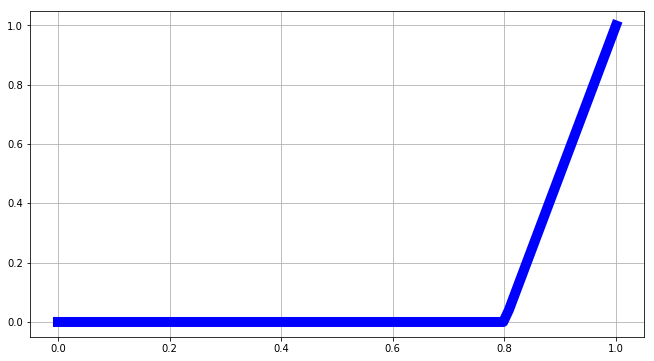

In [28]:
mesh1 = FiniteElementMesh(xL=0., xR=1., numNodes=6)
print(mesh1.h)

f = BasisFunction(mesh1, 5)
f.Plot()

Создаем "главный" класс - Solver:

In [32]:
class Solver:
    
    def __init__(self, mesh, function):
        self._mesh = mesh
        self._f = function
        self._numNodes = len(self._mesh._nodes)
        
        print('Number of nodes = %d' % self._numNodes, '\n')
        
        self._BasisFuncs = [BasisFunction(self._mesh, i) \
                            for i in range(0, self._numNodes)]
        
        
    
    def Solve(self):
        
        self._M = np.zeros((self._numNodes, self._numNodes))
        self._b = np.zeros(self._numNodes)
        
        integrationMethod = TrapeziumIntegral()
        integrationMethod.SetLeftBorder(self._mesh._nodes[0])
        integrationMethod.SetGrid(step=1e-3)
        
        # computing the mass matrix
        for i in range(0, self._numNodes):
            for j in range(0, self._numNodes):
                integrationMethod.SetFunction(\
                                lambda t: self._BasisFuncs[i](t)*self._BasisFuncs[j](t) \
                                             )
                # performing the integration
                self._M[i, j] = integrationMethod(self._mesh._nodes[-1])
        
        # computing the load vector
        for i in range(0, self._numNodes):
            integrationMethod.SetFunction(\
                                         lambda t: self._f(t)*self._BasisFuncs[i](t)\
                                         )
            # performing the integration
            self._b[i] = integrationMethod(self._mesh._nodes[-1])
        
        # solving linear system M*c = b
        self._c = np.linalg.solve(self._M, self._b)
                                
        # FOR DEBUG
        print(self._M)
        print(self._b, '\n')
        print('The coeffs are:', self._c)

    def EvaluateSolution(self, x):
        value = 0.
        for coeff, BasisFunc in zip(self._c, self._BasisFuncs):
            value += coeff*BasisFunc(x)
        return value
    
    def PlotSolution(self):
        xL = self._mesh._nodes[0]
        xR = self._mesh._nodes[-1]
        
        xData = np.linspace(xL, xR, 100)
        yData = np.array([self.EvaluateSolution(x) for x in xData])
        #print(yData)
        
        plt.figure(figsize=(11, 6))
        plt.plot(xData, yData, 'b-', lw=4)
        plt.grid('on')
        plt.show()

Number of nodes = 40 

[[ 0.00855352  0.00427147  0.         ...,  0.          0.          0.        ]
 [ 0.00427147  0.01708905  0.00427548 ...,  0.          0.          0.        ]
 [ 0.          0.00427548  0.01709122 ...,  0.          0.          0.        ]
 ..., 
 [ 0.          0.          0.         ...,  0.01709122  0.00427548  0.        ]
 [ 0.          0.          0.         ...,  0.00427548  0.01708905
   0.00427147]
 [ 0.          0.          0.         ...,  0.          0.00427147
   0.00855353]]
[  4.41175391e-06   6.16393476e-05   2.19369422e-04   4.80221098e-04
   8.40159451e-04   1.29532141e-03   1.83944664e-03   2.46425862e-03
   3.16414433e-03   3.92673650e-03   4.74231070e-03   5.60401319e-03
   6.49163479e-03   7.39877916e-03   8.31541657e-03   9.21538512e-03
   1.00986563e-02   1.09474423e-02   1.17394398e-02   1.24757816e-02
   1.31326227e-02   1.36962981e-02   1.41677655e-02   1.45177052e-02
   1.47451868e-02   1.48496161e-02   1.47981809e-02   1.46057081e-02
  

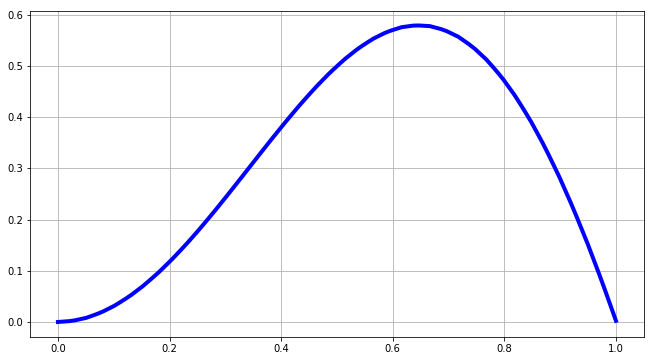

In [35]:
# тестирование
mesh2 = FiniteElementMesh(xL=0., xR=1., numNodes=40)

solver1 = Solver(mesh2, lambda t: t*m.sin(3.14*t))
solver1.Solve()
solver1.PlotSolution()